In [77]:
import pandas as pd
import numpy as np
etf_codelist = pd.read_csv("../../database/tw_maincode_etf__2025.csv")
list_ = etf_codelist['code'].values
_price = pd.read_parquet("../../database/tw_price.parquet")
op_df = _price.pivot_table(index='da', columns="code", values='op')
hi_df = _price.pivot_table(index='da', columns="code", values='hi')
lo_df = _price.pivot_table(index='da', columns="code", values='lo')
cl_df = _price.pivot_table(index='da', columns="code", values='cl')
vol_df = _price.pivot_table(index='da', columns="code", values='vol')
to_df = _price.pivot_table(index='da', columns="code", values='turnover')

In [78]:
start_da = '2020-01-01'
end_da = "2020-04-01"
to_df = to_df[to_df.columns.intersection(list_)].loc[start_da:end_da, :]
op_df = op_df[op_df.columns.intersection(list_)].loc[start_da:end_da, :]
cl_df = cl_df[cl_df.columns.intersection(list_)].loc[start_da:end_da, :]
hi_df = hi_df[hi_df.columns.intersection(list_)].loc[start_da:end_da, :]
lo_df = lo_df[lo_df.columns.intersection(list_)].loc[start_da:end_da, :]

hi_lo_log = np.log(hi_df / lo_df)
next_day_log = np.log(cl_df / op_df).shift(-1)

std = hi_lo_log.std()
profit = hi_lo_log.sum(axis=0)
len(std), len(std.dropna()), len(profit), len(profit[profit != 0.0])

(280, 187, 280, 186)

In [79]:
# R反L槓桿, K, U指數股票型, B+C債 cleaning
list_exclude = []; list_include = []
std_test = std.dropna(); profit_test = profit[profit != 0]

# test for the first time
for i in std_test.index:
    if i not in profit_test.index: print(i); list_exclude.append(i); continue;
    if "L" in i: list_exclude.append(i)
    elif "B" in i: list_exclude.append(i)
    elif "C" in i: list_exclude.append(i)
    elif "R" in i: list_exclude.append(i)
    else: list_include.append(i)

std_test = std_test[std_test.index.intersection(list_include)]
profit_test = profit_test[profit_test.index.intersection(list_include)]

# test again
for i in std_test.index:
    if i not in profit_test.index: print(i);

arr_test = np.column_stack((std_test, profit_test))
len(std_test), len(profit_test)

00643K TT Equity


(68, 68)

In [80]:
K = 2
centroids = arr_test[np.random.choice(len(arr_test), K, replace=False)]
clusters = [[] for _ in range(K)]


for point in arr_test:
    distances = []
    for i in range(len(centroids)):
        stacks = np.vstack([centroids[i], point]).T
        cov = np.cov(stacks)
        
        regularized_cov = cov + np.eye(cov.shape[0]) * 1e-5  # 添加小數值
        inv_cov = np.linalg.inv(regularized_cov)

        
        V = np.linalg.inv(inv_cov)
        diff = (centroids[i] - point)
        val = diff.T @ V @ diff
        distances.append(val)
    cluster_index = np.argmin(distances)
    clusters[cluster_index].append(point)
len(clusters[0]), len(clusters[1]), len(arr_test)

(9, 59, 68)

In [81]:
class KMeans:
    def __init__(self, tol=1e-5):
        self.tol = tol
        
    def clustering(self, data):
        pass
    
    def convergence_test(self, new_centroids, centroids) -> bool:
        if len(new_centroids) != len(centroids):
            return False
        return np.all(np.linalg.norm(new_centroids - centroids, axis=1) <= self.tol)
    
    def convergence_test_raw(self, new_centroids, centroids):
        if len(new_centroids) != len(centroids):
            return False
        
        for i in range(len(new_centroids)):
            if np.any(abs(new_centroids[i] - centroids[i])) > self.tol:  # 若任一元素超過誤差範圍
                return False
    

/var/folders/cb/s9sjq6dx01990v5hdvfhl7x40000gn/T/ipykernel_34737/3286321068.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_cl_df = cl_df[['0050 TT Equity']].pct_change()


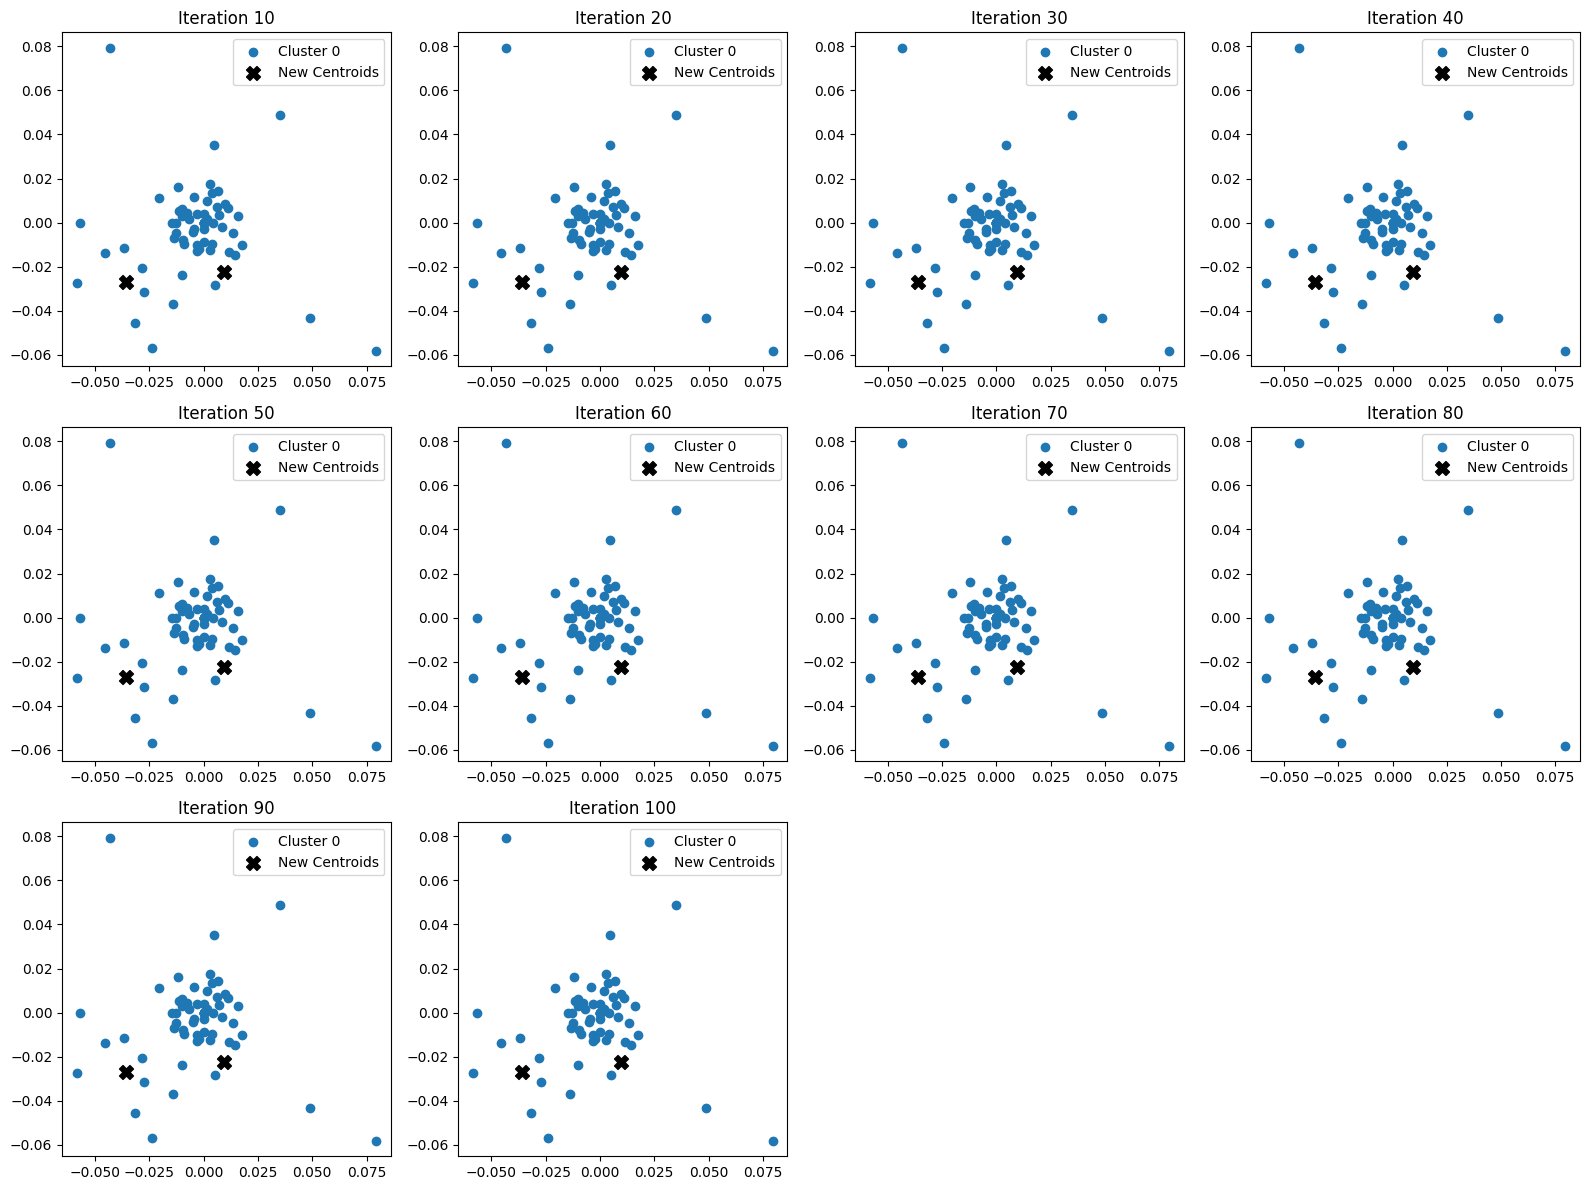

In [82]:
pct_cl_df = cl_df[['0050 TT Equity']].pct_change()
pct_cl_df['tom'] = pct_cl_df.shift(1)
pct_cl_df = pct_cl_df.iloc[2:]

data = np.array(pct_cl_df)
def distances_k_means(point_diff, method='eucldiean'):
    if method == 'eucldiean':
        return np.sqrt(
            np.sum(
                (point_diff) ** 2)
        )
    elif method == 'norm':
        return np.linalg.norm(point_diff)
    else: return None;
    
def mahalanobis_distance(point_diff, mean_vector, covariance_vector):
    return (point_diff - mean_vector) @ np.linalg.inv(covariance_vector) @ np.linalg.matrix_transpose(point_diff - mean_vector)

def convergence_test(a, b, tol=1e-5):
    if len(a) != len(b):
        return False
    
    for i in range(len(a)):
        print(a[i], b[i])
        if np.any(abs(a[i] - b[i])) > tol:  # 若任一元素超過誤差範圍
            return False
    
    return True  # 所有元素都接近
import numpy as np
import matplotlib.pyplot as plt
import math


def compute_sse(clusters, centroids):
    """計算 SSE (Sum of Squared Errors)"""
    sse = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            sse += np.linalg.norm(point - centroids[i])**2
    return sse

def convergence_test(new_centroids, centroids, tol=1e-5):
    return np.all(np.linalg.norm(new_centroids - centroids, axis=1) <= tol)

K = 3
num_iterations = 100
plot_interval = 10  # Change this to control how often the plot is generated

centroids = data[np.random.choice(len(data), K, replace=False)]

# List to store centroids for each iteration
centroids_history = []
sse_list = []
# Calculate how many plots will be shown based on plot_interval
plots_to_show = math.ceil(num_iterations / plot_interval)

# Dynamically calculate the number of rows and columns based on plots_to_show
cols = math.ceil(math.sqrt(plots_to_show))  
rows = math.ceil(plots_to_show / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  # Flatten the axes to make it easy to index

plot_counter = 0  # Counter to track how many plots we've made

for iteration in range(num_iterations):
    clusters = [[] for _ in range(K)]

    for point in data:
        distances = [distances_k_means(point - centroid) for centroid in centroids]
        cluster_index = np.argmin(distances)
        clusters[cluster_index].append(point)

    new_centroids = np.array([np.mean(cluster, axis=0) if cluster else centroids[i] 
                              for i, cluster in enumerate(clusters)])

    # Save the current centroids to centroids_history
    centroids_history.append(new_centroids)

    # Only plot every 'plot_interval' iterations
    if (iteration + 1) % plot_interval == 0:
        ax = axes[plot_counter]  # Get the next available axis to plot
        plot_counter += 1  # Increment the plot counter
        ax.set_title(f"Iteration {iteration + 1}")

        for i, cluster in enumerate(clusters):
            cluster_points = np.array(cluster)
            if len(cluster_points) > 0:
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
        ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c='black', marker='X', s=100, label='New Centroids')
        ax.legend()

    if convergence_test(new_centroids, centroids):
        print(f"K-Means 收斂於 Iteration {iteration+1}")
        break
    centroids = new_centroids  
    sse = compute_sse(clusters=clusters, centroids=centroids)
    sse_list.append(sse)
# Remove any remaining unused axes (in case plots_to_show is smaller than the total axes)
for i in range(plot_counter, len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()  
plt.show()